# QEK from A to Z
This notebook reproduces the results of [QEK](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.107.042615) by running the jupyter notebook.

At the end, you will be able to:
1. Find the embeddings of a molecular dataset
2. Emulate this dataset using EMU-FREE
3. Train an SVM with the QEK (Quantum Evolution Kernel) kernel and recover the performance reported in the paper.


In [1]:
from __future__ import annotations

from dataclasses import dataclass

import numpy as np
import pulser as pl
import torch_geometric.data as pyg_data
import torch_geometric.datasets as pyg_dataset
from tqdm.autonotebook import tqdm


/tmp/ipykernel_345752/4114388664.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Dataset preparation

In this part, we will prepare the PTC-FM dataset so that it can be submitted to the QPU (Quantum Processing Unit) of Pasqal.

In [3]:
# Loading of the original PTC-FM dataset
og_ptcfm = pyg_dataset.TUDataset(root="dataset", name="PTC_FM")

In [4]:
import qek.data.datatools as qek_datatools
from qek.utils import compute_register, is_disk_graph

# Graph embedding

A graph, molecular or otherwise, does not have coordinates in space. We therefore need to find a regular embedding as possible. 
In addition to this regularity, we must be sure that the embedding obtained by the function `add_graph_coord` is an **unit-disk graph embedding**.

Here, we want that the distance between two connected qubits is equal to `RADIUS=5.001` $\mu m$.
The `is_disk_graph` function check if the found embedding is an embedding of unit-disk graph, i.e. the distance between two connected nodes should be less than `RADIUS` and the distance between two disconnected nodes should be greater than `RADIUS`.

 

In [5]:
list_of_graph = []
RADIUS = 5.001
EPS = 0.01
for graph in tqdm(og_ptcfm):
    graph_with_pos = qek_datatools.add_graph_coord(graph=graph, blockade_radius=RADIUS)
    if is_disk_graph(graph_with_pos, radius=RADIUS+EPS):
        list_of_graph.append((graph_with_pos, graph.y.item()))

  0%|          | 0/349 [00:00<?, ?it/s]

is_disk_graph: nodes 2 and 48 are too close: 5.000999999999977
is_disk_graph: nodes 8 and 19 are too close: 3.2484870448721073
is_disk_graph: nodes 2 and 12 are too close: 4.483773936312436
is_disk_graph: nodes 2 and 8 are too close: 3.0907879777382243
is_disk_graph: nodes 0 and 18 are too close: 4.197397345723445
is_disk_graph: nodes 12 and 28 are too close: 5.000999999999997
is_disk_graph: nodes 7 and 17 are too close: 4.4837739363124305
is_disk_graph: nodes 6 and 16 are too close: 4.62960931539691
is_disk_graph: nodes 0 and 16 are too close: 4.012700577703665
is_disk_graph: nodes 4 and 8 are too close: 4.483773936312432
is_disk_graph: nodes 8 and 11 are too close: 5.001000000000013
is_disk_graph: nodes 1 and 11 are too close: 3.0082761985414286
is_disk_graph: nodes 2 and 18 are too close: 5.000999999999996
is_disk_graph: nodes 0 and 2 are too close: 5.000999999999994
is_disk_graph: nodes 0 and 12 are too close: 3.660986021838515
is_disk_graph: nodes 11 and 14 are too close: 3.421196

## Create a Pulser sequence

Once the embedding is found, we will create a pulser sequence that can be interpreted by the QPU or a Pasqal emulator. A sequence consists of a **register**, which means the position of qubits in a device and a **pulse** sequence.

The `create_sequence_from_graph` function is responsible for doing this. It checks if the positions of the qubits respect the constraints of the device (number of qubits, minimum and maximum distance between qubits, etc.) and create a register if the embedding pass all the tests. Finally, the pulse sequence is the same as that in the scientific paper, which is a constant pulse with values $\Omega = 2\pi$, $\delta = 0$ and a duration of $660 ns$.


In [5]:
# Create a sequence:

def create_sequence_from_graph(graph:pyg_data.Data, device=pl.devices.Device)-> pl.Sequence:
    if not qek_datatools.check_compatibility_graph_device(graph, device):
        raise ValueError(f"The graph is not compatible with {device}")
    reg = compute_register(data_graph=graph)
    seq = pl.Sequence(register=reg, device=device)
    Omega_max = 1.0 * 2 * np.pi
    t_max = 660
    pulse = pl.Pulse.ConstantAmplitude(
        amplitude=Omega_max,
        detuning=pl.waveforms.RampWaveform(t_max, 0, 0),
        phase=0.0,
    )
    seq.declare_channel("ising", "rydberg_global")
    seq.add(pulse, "ising")
    return seq

In [6]:
dataset_sequence = []

for graph, target in list_of_graph:
    # Some graph are not compatible with the AnalogDevice device
    try:
        dataset_sequence.append((create_sequence_from_graph(graph, device=pl.AnalogDevice), target))
    except ValueError as err:
        print(f"{err}")

The graph is not compatible with AnalogDevice
The graph is not compatible with AnalogDevice
The graph is not compatible with AnalogDevice
The graph is not compatible with AnalogDevice
The graph is not compatible with AnalogDevice
The graph is not compatible with AnalogDevice
The graph is not compatible with AnalogDevice
The graph is not compatible with AnalogDevice
The graph is not compatible with AnalogDevice
The graph is not compatible with AnalogDevice
The graph is not compatible with AnalogDevice
The graph is not compatible with AnalogDevice
The graph is not compatible with AnalogDevice
The graph is not compatible with AnalogDevice
The graph is not compatible with AnalogDevice


In [7]:
from pulser_simulation import QutipEmulator

A pulser sequence is all you need for a quantum calculation on a Pasqal QPU! Before submitting the calculation to an actual quantum computer, we must first verify that everything works by emulation. For this, Pasqal has developed `pulser_simulation`.

The code below allows us to emulate the entire "quantum compatible" PTC-FM dataset (i.e., whose embeddings are unit-disk and compatible with the device). However, we advise against running it for time reasons.

Fortunately, we have already emulated the entire PTC-FM compatible dataset. You just need to load it up 


In [12]:
processed_dataset = []
for seq, target in tqdm(dataset_sequence[0:2]): # Note: for performance reasons, we're just running samples `0:2`. You can run them all if you prefer.
    simul = QutipEmulator.from_sequence(sequence=seq)
    results = simul.run()


  0%|          | 0/279 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Loading the already existing dataset

In [13]:
processed_dataset = qek_datatools.load_dataset(file_path="ptcfm_processed_dataset.json")

Some properties of the newly created dataset:

In [14]:
print(f"Size of the quantum compatible dataset = {len(processed_dataset)}")

Size of the quantum compatible dataset = 279


Cherry picked register and pulse sequence:

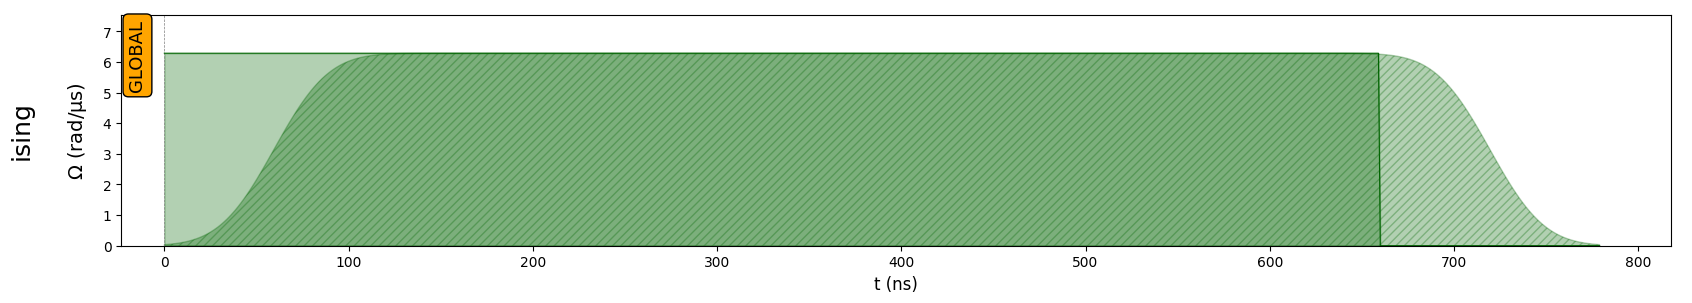

In [15]:
processed_dataset[64].sequence.draw()

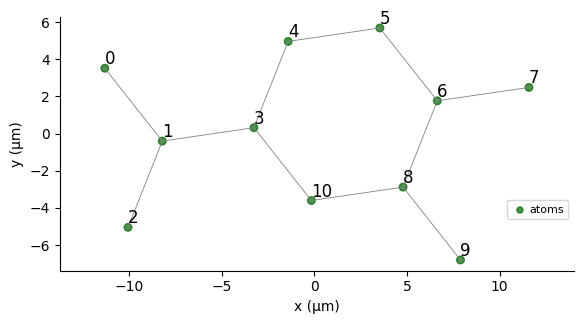

In [16]:
processed_dataset[64].sequence.register.draw(blockade_radius=5.01)

# Train your first quantum machine learning algorithm

At Pasqal, we prefer to talk about a hybrid algorithm, which is a classical algorithm that uses our quantum technology!

First, let's define the kernel QEK, which mathematicaly can be written like the following:
$$
K(G, G') = \exp \left( -\mu JS(P_G, P_{G'}) \right)
$$


where $\mu$ is an hyperparameter of our kernel. $JS$ is the Jensen-Shannon distance and $P_G$ is the probability distribution of excitation of graph $G$.

In [18]:
from qek.kernel import QekKernel


ImportError: cannot import name 'QekKernel' from 'qek.kernel' (/Users/roland/Desktop/Projects/quantum-evolution-kernel/qek/kernel/__init__.py)

In [89]:
import sklearn.svm as svm
from sklearn.metrics import balanced_accuracy_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold


@dataclass
class MLResults:
    """
    Stores the results of a machine learning model evaluation.
    
    This class provides attributes to store the mean and standard deviation of F1 score 
    and balanced accuracy, which are common metrics used in classification problems.

    Attributes:
        f1_score (float): Mean F1 score of the model.
        std_f1_score (float): Standard deviation of F1 scores across different folds.
        balanced_acc (float): Mean balanced accuracy of the model.
        std_balanced_acc (float): Standard deviation of balanced accuracies across different folds.
    """
    f1_score: float
    std_f1_score: float
    balanced_acc: float
    std_balanced_acc: float


def train_and_evaluate_ml_model(K: np.ndarray, targets: list[int], seed1: int = None,
                                seed2: int = None):
    """
    Trains and evaluates a Support Vector Machine (SVM) model on the provided kernel.

    It employs a stratified k-fold cross-validation strategy with repeated splits
    to ensure robustness and reliability of the results.

    Parameters:
        K (np.ndarray): The precomputed kernel matrix.
        targets (list[int]): A list of target values for the training data.
        seed1 (int, optional): The random state used for stratified k-fold cross-validation.
            Defaults to None.
        seed2 (int, optional): The random state used for the SVM estimator. Defaults to None.

    Returns:
        MLResults: An instance containing the mean and standard deviation of F1 score and
            balanced accuracy.
    """
    C_list = np.linspace(0.001, 100, 100)
    param_grid = {"C": C_list}
    scoring = {"balanced_accuracy": make_scorer(balanced_accuracy_score),
                "f1_score": make_scorer(f1_score, average="weighted")
                }

    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=seed1)


    estimator = svm.SVC(kernel="precomputed", random_state=seed2)
    grid_search = GridSearchCV(estimator, param_grid, scoring=scoring,
                                    cv=skf, refit=False, n_jobs=8)
    

    result = grid_search.fit(K, targets).cv_results_
    max_f1_score = np.mean(result["mean_test_f1_score"]) 
    final_f1_std = np.mean(result["std_test_f1_score"])
    max_bal_acc = np.mean(result["mean_test_balanced_accuracy"]) 
    std_bal_acc = np.mean(result["std_test_balanced_accuracy"])
    final_score = MLResults(f1_score=max_f1_score, std_f1_score=final_f1_std,
                            balanced_acc=max_bal_acc, std_balanced_acc=std_bal_acc)
    return final_score

## Kernel definition

the parameter $\mu$ controls the rate of exponential decay. A large value of $\mu$ makes QEK very sensitive to small variations of the Jensen-Shanon distance. Conversely, when $\mu$ is small, the kernel is less affected by small variations in of $JS$.

In [90]:
kernel = QekKernel(mu=2.)

The object `kernel` allows you to compare two processed graphs with QEK ! A High value (close to 1.) means a big similarity between the graphs, while a value close to 0 means a small graph similarity. Let's try that:

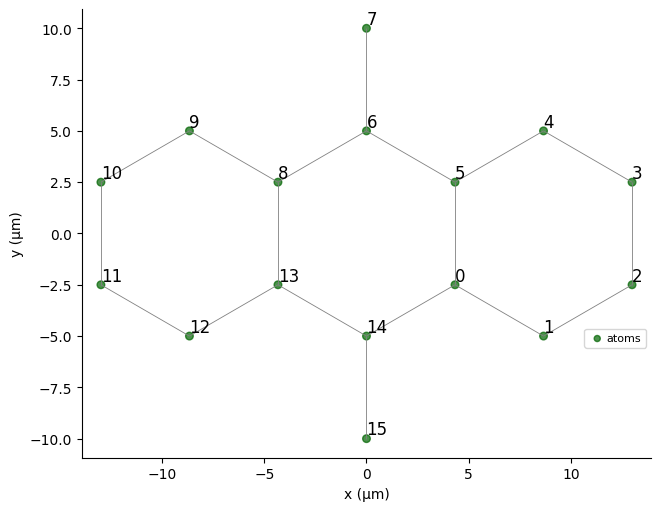

None

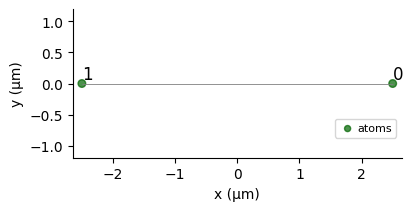

None

QEK value : 0.3792634865270918


In [95]:
display(processed_dataset[2].sequence.register.draw(blockade_radius=5.001))
display(processed_dataset[0].sequence.register.draw(blockade_radius=5.001))
print(f"QEK value : {kernel(graph_1=processed_dataset[0], graph_2=processed_dataset[2])}")

## Training and evaluation

In this part, we will calculate the kernel on the entire dataset of PTC-FM. We obtain an NxN matrix (where N is the number of graphs in the dataset). This matrix contains the similarities two by two of the graphs.

This precomputed kernel will allow us to evaluate the algorithm QEK. We will use an SVM (Support Vector Machine) to learn how to predict the toxicity of a molecule based on the precomputed kernel. This task is handled with the `train_and_evaluate_ml_model`.

In [ ]:
train_kernel = kernel.create_train_kernel_matrix(processed_dataset)
y_tot = [data.target for data in processed_dataset]

In [ ]:
results = train_and_evaluate_ml_model(K = train_kernel, targets=y_tot, seed1=42, seed2=42)

### Results

We are using two metrics:
- The F1 score is a way to measure how well a model performs, especially when the data is uneven (e.g., more examples of one category than another). It combines two important aspects: how precise the model is (how many of the predicted positives are actually positive) and how well it captures all the actual positives (recall). It provides a single number that balances these two aspects, making it useful for evaluating performance in real-world scenarios where some categories are much more common than others.

- Balanced accuracy is a method to evaluate a model's performance fairly, even when the data is imbalanced (e.g., one category is much more frequent than others). Instead of just looking at overall accuracy, which can be misleading in such cases, balanced accuracy considers how well the model performs for each category separately and then averages these performances. This ensures that the evaluation is not skewed by the more common categories, giving a more honest picture of the model's effectiveness across all categories.


Inside the `train_and_evaluate_ml_model`function, we split our data multiple times to ensure each fold is representative of the overall class distribution, helping to mitigate bias. The mean value and standard deviation (std) of each metrics from this process provide an average performance measure and the variability of that performance across different data splits, giving you a robust understanding of your model's consistency and reliability.


In [97]:
print(f"Mean F1 score = {results.f1_score}")
print(f"Standard deviation of F1 score = {results.std_f1_score}")
print(f"Mean balanced accuracy {results.balanced_acc}")
print(f"Standard deviation of balanced accuracy {results.std_balanced_acc}")

Mean F1 score = 0.5908724583578355
Standard deviation of F1 score = 0.05587930335561074
Mean balanced accuracy 0.5786542572463768
Standard deviation of balanced accuracy 0.05476178687836319
